<a href="https://colab.research.google.com/github/mekhi-woods/HiloCATsSN1991bg/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# START-UP
!pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple snpy
!pip install requests
!git clone https://github.com/mekhi-woods/HiloCATsSN1991bg.git

In [ ]:
"""
Plotting 91bg like 1a to get an idea of what they look like
"""
import matplotlib.pyplot as plt
import numpy as np

FILTER_WHEEL = ['u', 'g', 'r', 'i', 'B', 'V0']

if __name__ == '__main__':
    KrisciunasPath = "/content/HiloCATsSN1991bg/targetLists/91bglike_justnames.txt"
    KrisciunasNames = np.genfromtxt(KrisciunasPath, dtype=str, delimiter=', ')

    allCPSPhot = "/content/HiloCATsSN1991bg/data/CSPdata/SN_photo.dat"
    allCPSPhotData = np.genfromtxt(allCPSPhot, dtype='str')

    names = allCPSPhotData[:,0]
    filters = allCPSPhotData[:,1]
    time = allCPSPhotData[:,2]
    light = allCPSPhotData[:,3]
    err = allCPSPhotData[:,4]

    plt.figure(figsize=(10,6))
    sigma = 1
    for tar in KrisciunasNames:
        for n in range(len(FILTER_WHEEL)):
            # output_names = names[(names == tar) & (filters == FILTER_WHEEL[n])]
            output_light = light[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64')
            output_time = time[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64') + 53000
            output_err = err[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64')
            plt.errorbar(output_time, output_light, yerr=output_err*sigma, fmt='o', label=FILTER_WHEEL[n])

        plt.title(tar); plt.xlabel('Time [MJD]'); plt.ylabel('Intensity [mag]')
        plt.gca().invert_yaxis()
        plt.legend()
        # plt.savefig('save\\'+str(tar)+'.png')
        plt.show()
        break


[ 1 / 13] Fiting data for SN2005bl...
Redshift:		 z = 0.0241
SNooPy Distance: 	 mu = 35.0762
Manual Distance: 	 mu = 35.4886


[ 2 / 13] Fiting data for SN2005ke...
Redshift:		 z = 0.0049
SNooPy Distance: 	 mu = 31.3061
Manual Distance: 	 mu = 31.5833


[ 4 / 13] Fiting data for SN2006gt...
Redshift:		 z = 0.0448
SNooPy Distance: 	 mu = 36.305
Manual Distance: 	 mu = 34.75


[ 5 / 13] Fiting data for SN2006mr...
Redshift:		 z = 0.0059
SNooPy Distance: 	 mu = 31.7571
Manual Distance: 	 mu = 31.1528


[ 6 / 13] Fiting data for SN2007N_...
Redshift:		 z = 0.0129
SNooPy Distance: 	 mu = 33.7883
Manual Distance: 	 mu = 32.9569


[ 7 / 13] Fiting data for SN2007al...
Redshift:		 z = 0.0122
SNooPy Distance: 	 mu = 33.6794
Manual Distance: 	 mu = 33.818


[ 9 / 13] Fiting data for SN2007ba...
Redshift:		 z = 0.0385
SNooPy Distance: 	 mu = 36.0541
Manual Distance: 	 mu = 34.293


[ 11 / 13] Fiting data for SN2008bi...
Redshift:		 z = 0.0134
SNooPy Distance: 	 mu = 33.8382
Manual Distance: 	 mu 

<Figure size 640x480 with 0 Axes>

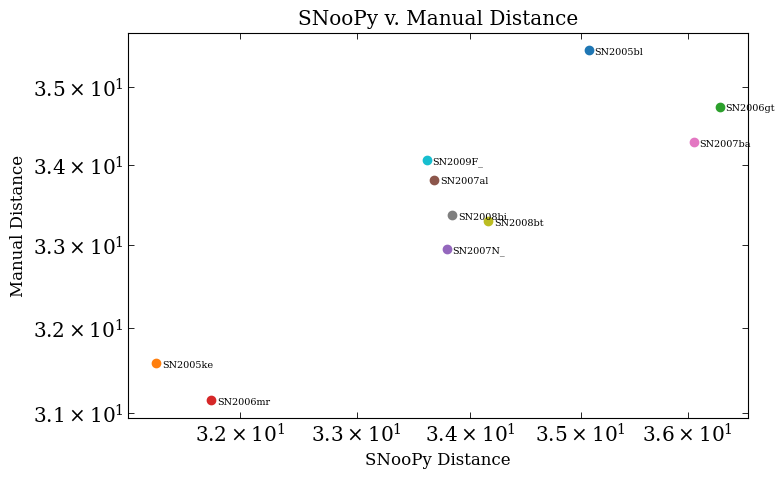

In [22]:
"""
SNooPy fitting on CSP data
"""
import matplotlib.pyplot as plt
import numpy as np
import snpy
import os

def recover_dir():
    if os.path.exists('/content/saved_models') == False:
        os.mkdir('/content/saved_models')
    return

def snpy_fit(filePath, model='max_model', shapeParam='dm15', BandsToFit = ['B','g','r','i'], summarize=True):
    s = snpy.get_sn(filePath)

    # Set model parameters
    s.choose_model(model, stype=shapeParam)
    s.set_restbands() # Auto pick appropriate rest-bands

    # Fit data -- using David configurations
    fitargs = {'mangle':1,'calibration':0} # I don't remember what calibration is
    s.fit(BandsToFit,
          dokcorr=True,
          k_stretch=False,
          reset_kcorrs=True,
          **fitargs)

    # Show results
    if summarize:
        s.summary()
        # for param in s.parameters:
        #     print("{} = {} +/- {}".format(param, s.parameters[param], s.errors[param]))
    return s

def manual_muist_calc(s, M_B = -16.38):
    peakmB = s.get_max(['B'], use_model=True)[1][0]
    return peakmB - M_B

def KrisciunasFitting(paths, model='EBV_model2', shape='st', bands=['B','g','r','i'], output=False, saveDist=True, plotDvD=True):
    # SNeObjs = []
    n_old = [0,1,2,3,4,5,6,7,8,9,10,11,12]
    valid_n = [0,1,3,4,5,6,8,10,11,12]
    problem_children = [2,7,9]

    all_snpy_mu, all_manual_mu, all_names = np.array([]), np.array([]), np.array([])

    for n in valid_n:
        tarName = paths[n][39:47]
        tarSave = '/content/saved_models/'+tarName+'_'+model+'.snpy'
        all_names = np.append(all_names, tarName)
        print('[ '+str(n+1)+' / '+str(len(n_old))+'] Fiting data for '+tarName+'...')

        # Create/Retrieve Fit
        if os.path.exists(tarSave):
            s_n = snpy.get_sn(tarSave)
        else:
            s_n = snpy_fit(paths[n], model=model, shapeParam=shape, BandsToFit=bands, summarize=output) # Enter snpy fit function
            s_n.save(tarSave)

        # Pull SNooPY distance
        snpy_mu = s_n.get_distmod() # Nab paramaters from SNe objects
        all_snpy_mu = np.append(all_snpy_mu, snpy_mu)

        # Manually calculate distance
        manual_mu = manual_muist_calc(s_n, M_B = -16.38) # in B-filter, using M_B of SN1991bg
        all_manual_mu = np.append(all_manual_mu, manual_mu)

        # Print info
        print('Redshift:\t\t z = '+str(s_n.z))
        print('SNooPy Distance: \t mu = '+str(round(snpy_mu, 4)))
        print('Manual Distance: \t mu = '+str(round(manual_mu, 4)))
        print('\n')
        plt.clf()

    # Save distances
    if saveDist:
        with open('KrisciunasFitting_calc_dist.txt', 'w') as f:
            for i in range(len(all_snpy_mu)):
                f.write(str(all_names[i])+'\n')
                f.write('Redshift:\t\t\t z = '+str(s_n.z)+'\n')
                f.write('SNooPy Distance: \t mu = '+str(round(all_snpy_mu[i], 4))+'\n')
                f.write('Manual Distance: \t mu = '+str(round(all_manual_mu[i], 4))+'\n\n')

    # Plot manual_mu vs snpy_mu
    if plotDvD:
        print("Ploting differences in distance calculations...")
        plt.figure(figsize=(8,5))
        for i in range(len(all_snpy_mu)):
            plt.loglog(all_snpy_mu[i], all_manual_mu[i], 'o')
            plt.text(all_snpy_mu[i]+0.05, all_manual_mu[i]-0.05, all_names[i], fontsize='xx-small')
        plt.title("SNooPy v. Manual Distance"); plt.xlabel('SNooPy Distance'); plt.ylabel('Manual Distance')
        plt.savefig('snpy_v_man_dist.png')
        plt.show()
    return (all_names, all_snpy_mu, all_manual_mu)

if __name__ == '__main__':
    recover_dir()

    # Initalize File -- SN2005ke
    KrisciunasNames = np.genfromtxt("/content/HiloCATsSN1991bg/targetLists/91bglike_justnames.txt", dtype=str, delimiter=', ')
    filePaths = []
    for tar in KrisciunasNames:
        filePaths.append('/content/HiloCATsSN1991bg/data/CSPdata/'+str(tar)+'_snpy.txt')

    KrisciunasDistances = KrisciunasFitting(paths=filePaths,
                                            model='EBV_model2',
                                            shape='st',
                                            bands=['B','g','r','i'],
                                            output=False,
                                            saveDist=True,
                                            plotDvD=True)



In [ ]:
import numpy as np
import requests
from requests.auth import HTTPBasicAuth
import urllib.request
import os

API_TOKEN = "7f4e1dee8f52cf0c8cdaf55bf29d04bef4810fb4"

def main():

        #pickle = np.load('tmp.npz', allow_pickle=True)
        #data = pickle['data']

        data = requests.post(
            'https://star.pst.qub.ac.uk/sne/atlas4/api/objectlist/',
            headers={'Authorization': f'Token {API_TOKEN}'},
            data={'objectlistid':2}
        ).json()

        np.savez('tmp.npz', data=data)

        count = 0
        for d in data:
            if d['observation_status'] is not None and d['observation_status'].startswith('SN Ia') and '91bg' in d['observation_status']:
                print(d['atlas_designation'],d['observation_status'].replace(' ',''),d['ra'],d['dec'])
                count += 1

                ids = d['id']
                base_url = 'https://star.pst.qub.ac.uk/sne/atlas4/lightcurveforced/1161048951013729300/'
                new_url = base_url.replace('1161048951013729300/',str(ids))
                print(new_url)

                idfile = '/content/ATLAS_ids/' + str(ids)+'.txt'
                if os.path.exists(idfile):
                    continue
                urllib.request.urlretrieve(str(new_url), str(idfile))
                print(idfile)

            if count > 300:
                break

if __name__ == '__main__':
    print (main())